In [1]:
'''
GCBC with point maze (with multi-goal + color state space)
'''
from __future__ import print_function, division, unicode_literals
%load_ext autoreload
%autoreload 2
import math
import time
import os
import copy
import unicodedata
import string
import re
import random
from io import open

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import distributions as pyd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode - o

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/andipeng/miniforge3/envs/aligning-construals/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define simple MLP
class MLP(nn.Module):
    def __init__(
        self, input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None
    ):
        super().__init__()
        self.trunk = mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod)
        self.apply(weight_init)

    def forward(self, x):
        return self.trunk(x)
    
def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), nn.ReLU(inplace=True)]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(inplace=True)]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)

In [10]:
# Goal-conditioned Point Maze (with multi state + color)
# self.color = [0 = red, 1 = yellow, 2 = green, 3 = orange]
import gym
import gym.wrappers

class PointEnvComplex(gym.Env):
    def __init__(self):
        self.pos = np.array([0., 0.])
        self.obj1_pos = np.array([-1., -1.])
        self.obj1_color = np.array([0.])
        self.obj2_pos = np.array([-1., -1.])
        self.obj2_color = np.array([0.])
        self.obj3_pos = np.array([-1., -1.])
        self.obj3_color = np.array([0.])
        self.goal_color = np.array([0.])
        self.max_vel = 1.
        self.observation_space = gym.spaces.Box(
            -np.inf * np.ones(12), np.inf * np.ones(12)
        )
        self.action_space = gym.spaces.Box(-np.ones(2), np.ones(2))
        self.action_space.seed(0)
        self.observation_space.seed(0)

    def reset(self):
        self.pos = np.zeros(2)
        self.obj1_pos = np.zeros(2)
        self.obj1_color = np.zeros(1)
        self.obj2_pos = np.zeros(2)
        self.obj2_color = np.zeros(1)
        self.obj3_pos = np.zeros(2)
        self.obj3_color = np.zeros(1)
        self.goal_pos = np.zeros(2)
        self.goal_color = np.zeros(1)
        return self.get_obs()

    def get_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj2_pos, self.obj2_color, self.obj3_pos, self.obj3_color, self.goal_color]))

    def step(self, action: np.ndarray):
        self.pos += self.max_vel*action
        reward = -np.linalg.norm((self.pos - self.goal_pos))
        return self.get_obs(), reward, False, {}
    
    def reward_fn(self, state):
        return -torch.linalg.norm((state - torch.Tensor(self.goal).to(device)), dim=-1)

    def get_color(env_value: int):
        if env_value == 0:
            return 'red'
        elif env_value == 1:
            return 'yellow'
        elif env_value == 2:
            return 'green'
        elif env_value == 3:
            return 'orange'
    
    def set_goalpos_from_color(color: int):
        
    
env1 = PointEnvComplex()

In [15]:
def plot_env(env):
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    colors = sns.color_palette("hls", 10)
    
    plt.scatter([env.pos[0]],[env.pos[1]], marker='o', color='blue', s=20) # plots agent
    plt.scatter([env.obj1_pos[0],[env.obj1_pos[1]], marker='x', color=get_color(env1.obj1_color), s=20) # plots obj1
    plt.scatter([env.obj2_pos[0],[env.obj2_pos[1]], marker='x', color=get_color(env1.obj2_color), s=20) # plots obj2
    plt.scatter([env.obj3_pos[0],[env.obj3_pos[1]], marker='x', color=get_color(env1.obj3_color), s=20) # plots obj3

SyntaxError: invalid syntax (3572142856.py, line 7)

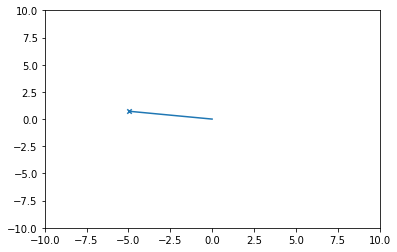

In [7]:
plt.xlim(-10, 10)
plt.ylim(-10, 10)
colors = sns.color_palette("hls", 10)

# Collect random rollouts from the environment, store it in some datasets
num_trajs = 1
train_trajs = []
angles = []

for tn in range(num_trajs):
    o = env1.reset().copy()
    angle = np.random.uniform(0, 2*np.pi) # samples angle in radians
    end_pos = np.array([5*np.cos(angle), 5*np.sin(angle)])
    env1.goal_pos = end_pos
    delta_vector = end_pos# - env1.pos # calculates distance to goal pos
    o = env1.get_obs()
    traj = {'obs': [],'action': [], 'next_obs': []}
    for i in range(100):
        ac = delta_vector * 0.01 # Go in direction between start and end
        no, r, d, _ = env1.step(ac)
        traj['obs'].append(o.copy())
        traj['action'].append(ac.copy())
        traj['next_obs'].append(no.copy())
        o = no.copy()
    traj['obs'] = np.array(traj['obs'])
    traj['action'] = np.array(traj['action'])
    traj['next_obs'] = np.array(traj['next_obs'])
    plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots generated trajectory
    plt.scatter([end_pos[0]],[end_pos[1]], marker='x', s=20) # plots end goal
    train_trajs.append(traj)
    angle_curr = np.arctan2(traj['obs'][-1, 0], traj['obs'][-1, 1])
    angles.append(angle_curr.copy())